# Codes for scrabing complaint data

These codes are used to finish web scraping on Insurance sector from 2024-01-01 to 2024-06-30. 'scrape.py' is provided by professors.

In [1]:
# By using these codes, metadata.csv in provided dataset can be obtained.
# %run scrape.py get-metadata --industry-sector "payment-protection-insurance,insurance" --from "2024-01-01" --to "2024-06-30"

In [2]:
# By using these codes, all PDF files in decisions folder in provided dataset can be obtaiend.
# %run scrape.py download-decisions

# Codes for visualization and models

In [3]:
!pip install yake

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.0/336.0 kB 7.2 MB/s eta 0:00:00


In [4]:
# For data import and prerpocessing
import os
import glob
from pypdf import PdfReader
import pandas as pd
import re
import spacy
import nltk
from nltk.corpus import stopwords

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.tokenize import regexp_tokenize
import yake
from collections import Counter

# For model building
import torch
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, load_metric
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import wandb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix
import spacy
from spacy.tokens import DocBin
from spacy.training import Example
from spacy.util import minibatch, compounding

2024-08-07 21:00:21.720128: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 21:00:21.720280: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 21:00:21.876195: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Data Import

In [5]:
# import paths of all PDF files (3212)
pdf_path = '/kaggle/input/half-year-data/decisions/decisions'
pdf_search_pattern = os.path.join(pdf_path, '*.pdf')
pdf_files_paths = glob.glob(pdf_search_pattern)

In [6]:
# 3212 complaint cases
metadata = pd.read_csv('/kaggle/input/half-year-data/metadata.csv')

In [7]:
# 167 labelled data
train_classif = pd.read_csv('/kaggle/input/half-year-data/167labelled.csv')

### PDF extraction

In [8]:
# This function iterates all paths and extracts text from PDF based on the number of pages.
def extract_from_PDF(pdf_path):
    reader = PdfReader(pdf_path)
    text = ""
    for num in range(len(reader.pages)):
        page = reader.pages[num]
        text += page.extract_text()  
    return text

# This function extracts required text according to the headings in PDF files.
def extract_by_headings(text, titles):
    segments = {title: "" for title in titles}
    current_title = None
    for line in text.split('\n'):
        if any(title in line for title in titles):
            current_title = next(title for title in titles if title in line)
        elif current_title:
            # join all text in a string
            segments[current_title] += line + " "
    return segments

In [9]:
# Extract content in 'The complaint' and 'What happened'
titles = ["The complaint", "What happened"]
features = []
for path in pdf_files_paths:
    pdftext = extract_from_PDF(path)
    segments = extract_by_headings(pdftext, titles)
    features.append(segments)

# Extract decision id from Path, prepare for merging data
pdf = pd.DataFrame(features)
pdf.insert(0, "Path", pdf_files_paths)
pdf['id'] = pdf['Path'].str.extract(r'([^/]+)\.pdf$', expand=False)
pdf.head()

,Path,The complaint,What happened,id
0,/kaggle/input/half-year-data/decisions/decisio...,Mr P is complaining about the amount AXA Insur...,In November 2021 Mr P says he noticed a potent...,DRN-4688502
1,/kaggle/input/half-year-data/decisions/decisio...,Ms F has complained that First Complete Ltd tr...,The background to this matter is well known to...,DRN-4651614
2,/kaggle/input/half-year-data/decisions/decisio...,Mr S complained that Admiral Insurance (Gibral...,"In June 2023 Mr S made a claim to his insurer,...",DRN-4660693
3,/kaggle/input/half-year-data/decisions/decisio...,Mr G and Ms S complain about the service recei...,Mr G and Ms S have a home insurance policy wit...,DRN-4690458
4,/kaggle/input/half-year-data/decisions/decisio...,Mrs R is unhappy with the service received fr...,Aviva initially covered Mrs R’s physiotherapy...,DRN-4800420


## Data Prerpocessing

### PDF preprocessing

In [10]:
# This function is used to extract first 100 words of total text
# design for preparation of Insurance Classification Model training set
def get_first_100_words(text):
    words = text.split()
    first_100_words = " ".join(words[:100])
    return first_100_words

# This function is used to preserve all words and numbers
def keep_words(text):
    cleaned_text = re.sub(r'[^a-zA-Z0-9]', ' ', text).lower()
    return cleaned_text

In [11]:
pdf_ = pdf.dropna() # remove na cases
pdf_['cleaned_complaint'] = pdf_['The complaint'].apply(keep_words)
pdf_['What happened_100'] = pdf_['What happened'].apply(get_first_100_words)
pdf_['cleaned_happened'] = pdf_['What happened_100'].apply(keep_words)
# Join all cleaned complaint text and first 100 words in cleaned what happened
pdf_['text'] = pdf_['cleaned_complaint'] + ' ' + pdf_['cleaned_happened']
pdf_.head()

,Path,The complaint,What happened,id,cleaned_complaint,What happened_100,cleaned_happened,text
0,/kaggle/input/half-year-data/decisions/decisio...,Mr P is complaining about the amount AXA Insur...,In November 2021 Mr P says he noticed a potent...,DRN-4688502,mr p is complaining about the amount axa insur...,In November 2021 Mr P says he noticed a potent...,in november 2021 mr p says he noticed a potent...,mr p is complaining about the amount axa insur...
1,/kaggle/input/half-year-data/decisions/decisio...,Ms F has complained that First Complete Ltd tr...,The background to this matter is well known to...,DRN-4651614,ms f has complained that first complete ltd tr...,The background to this matter is well known to...,the background to this matter is well known to...,ms f has complained that first complete ltd tr...
2,/kaggle/input/half-year-data/decisions/decisio...,Mr S complained that Admiral Insurance (Gibral...,"In June 2023 Mr S made a claim to his insurer,...",DRN-4660693,mr s complained that admiral insurance gibral...,"In June 2023 Mr S made a claim to his insurer,...",in june 2023 mr s made a claim to his insurer ...,mr s complained that admiral insurance gibral...
3,/kaggle/input/half-year-data/decisions/decisio...,Mr G and Ms S complain about the service recei...,Mr G and Ms S have a home insurance policy wit...,DRN-4690458,mr g and ms s complain about the service recei...,Mr G and Ms S have a home insurance policy wit...,mr g and ms s have a home insurance policy wit...,mr g and ms s complain about the service recei...
4,/kaggle/input/half-year-data/decisions/decisio...,Mrs R is unhappy with the service received fr...,Aviva initially covered Mrs R’s physiotherapy...,DRN-4800420,mrs r is unhappy with the service received fr...,Aviva initially covered Mrs R’s physiotherapy...,aviva initially covered mrs r s physiotherapy...,mrs r is unhappy with the service received fr...


In [12]:
# Match claim outcomes for 3212 data
merge_meta = pd.merge(metadata, pdf_, left_on='decision_id',right_on='id')
pdf_clean = merge_meta.drop(columns=["location", "title", "extras", "tag", "Path", "id"])
pdf_clean.head()

,decision_id,date,company,decision,The complaint,What happened,cleaned_complaint,What happened_100,cleaned_happened,text
0,DRN-4841485,11 Jun 2024,Mulsanne Insurance Company Limited,Not upheld,Mr H complains that Mulsanne Insurance Company...,Mr H held a motor insurance policy with Mulsan...,mr h complains that mulsanne insurance company...,Mr H held a motor insurance policy with Mulsan...,mr h held a motor insurance policy with mulsan...,mr h complains that mulsanne insurance company...
1,DRN-4798432,11 Jun 2024,One Insurance Limited,Upheld,Miss T complains about delays in assessing her...,Miss T had a home insurance policy with legal ...,miss t complains about delays in assessing her...,Miss T had a home insurance policy with legal ...,miss t had a home insurance policy with legal ...,miss t complains about delays in assessing her...
2,DRN-4841285,11 Jun 2024,Ageas Insurance Limited,Upheld,Mr G is a sole trader. He complains that Ageas...,Mr G operates in the motor industry. He took o...,mr g is a sole trader he complains that ageas...,Mr G operates in the motor industry. He took o...,mr g operates in the motor industry he took o...,mr g is a sole trader he complains that ageas...
3,DRN-4842247,11 Jun 2024,AWP P&C S.A.,Not upheld,Mr and Mrs E have complained that AWP P&C SA d...,Mr and Mrs E and their two children were on ho...,mr and mrs e have complained that awp p c sa d...,Mr and Mrs E and their two children were on ho...,mr and mrs e and their two children were on ho...,mr and mrs e have complained that awp p c sa d...
4,DRN-4846269,11 Jun 2024,esure Insurance Limited,Not upheld,Mr H and Mr H complain that esure Insurance Li...,Mr H has car insurance with esure. In Februar...,mr h and mr h complain that esure insurance li...,Mr H has car insurance with esure. In February...,mr h has car insurance with esure in february...,mr h and mr h complain that esure insurance li...


### Labelled data preprocessing

In [13]:
# Match complaint text for 167 labelled data
trainset = pd.merge(train_classif, pdf_clean, left_on='decision_id',right_on='decision_id')
trainset['cleaned_insurance'] = trainset['insurance'].str.strip().str.lower()
trainset_clean = trainset.drop(columns=["insurance", "The complaint", "What happened",
                                       "What happened_100", "cleaned_happened"])
trainset_clean.head()

,decision_id,date,company,decision,cleaned_complaint,text,cleaned_insurance
0,DRN-4490442,17 May 2024,U K Insurance Limited,Not upheld,x complains that the amount uk insurance limit...,x complains that the amount uk insurance limit...,motor insurance
1,DRN-4512482,21 May 2024,Wakam,Upheld,mrs e complains that wakam rejected a clam on ...,mrs e complains that wakam rejected a clam on ...,household and commercial property insurance
2,DRN-4516775,23 May 2024,China Taiping Insurance (UK) Co Ltd,Upheld,m complains about china taiping insurance uk ...,m complains about china taiping insurance uk ...,household and commercial property insurance
3,DRN-4517892,16 May 2024,AXA Insurance UK Plc,Not upheld,mr and mrs a are complaining that they think a...,mr and mrs a are complaining that they think a...,household and commercial property insurance
4,DRN-4518508,17 May 2024,Liverpool Victoria Insurance Company Limited,Not upheld,ms b complains liverpool victoria insurance co...,ms b complains liverpool victoria insurance co...,household and commercial property insurance


In [14]:
# Table 2 in report
trainset_clean['cleaned_insurance'].value_counts()

cleaned_insurance
household and commercial property insurance    52
motor insurance                                50
travel insurance cover                         21
life and critical illness cover                11
medical insurance                              10
legal expenses and monetary loss insurance      9
personal belongings insurance (standalone)      6
being categorised                               4
animal insurance                                4
Name: count, dtype: int64

### Data to be classified

In [15]:
# remaining data to be classified: remove the labelled 167 data from 3212 data
common_df = pd.merge(trainset_clean, pdf_clean, left_on='decision_id',
                     right_on='decision_id', how='inner')
to_be_classify = pdf_clean[~pdf_clean['decision_id'].isin(common_df['decision_id'])]
to_be_classify.head()

,decision_id,date,company,decision,The complaint,What happened,cleaned_complaint,What happened_100,cleaned_happened,text
0,DRN-4841485,11 Jun 2024,Mulsanne Insurance Company Limited,Not upheld,Mr H complains that Mulsanne Insurance Company...,Mr H held a motor insurance policy with Mulsan...,mr h complains that mulsanne insurance company...,Mr H held a motor insurance policy with Mulsan...,mr h held a motor insurance policy with mulsan...,mr h complains that mulsanne insurance company...
1,DRN-4798432,11 Jun 2024,One Insurance Limited,Upheld,Miss T complains about delays in assessing her...,Miss T had a home insurance policy with legal ...,miss t complains about delays in assessing her...,Miss T had a home insurance policy with legal ...,miss t had a home insurance policy with legal ...,miss t complains about delays in assessing her...
2,DRN-4841285,11 Jun 2024,Ageas Insurance Limited,Upheld,Mr G is a sole trader. He complains that Ageas...,Mr G operates in the motor industry. He took o...,mr g is a sole trader he complains that ageas...,Mr G operates in the motor industry. He took o...,mr g operates in the motor industry he took o...,mr g is a sole trader he complains that ageas...
3,DRN-4842247,11 Jun 2024,AWP P&C S.A.,Not upheld,Mr and Mrs E have complained that AWP P&C SA d...,Mr and Mrs E and their two children were on ho...,mr and mrs e have complained that awp p c sa d...,Mr and Mrs E and their two children were on ho...,mr and mrs e and their two children were on ho...,mr and mrs e have complained that awp p c sa d...
4,DRN-4846269,11 Jun 2024,esure Insurance Limited,Not upheld,Mr H and Mr H complain that esure Insurance Li...,Mr H has car insurance with esure. In Februar...,mr h and mr h complain that esure insurance li...,Mr H has car insurance with esure. In February...,mr h has car insurance with esure in february...,mr h and mr h complain that esure insurance li...


## Explotary Data Analysis

### Insurance Type Proportion

#### Insurance Classification Model (ICM)

In [16]:
# This function designs for evaluating the performance of ICM
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # ensure logits is a PyTorch Tensor
    if isinstance(logits, np.ndarray):
        logits = torch.tensor(logits)
    if isinstance(labels, np.ndarray):
        labels = torch.tensor(labels)
    predictions = torch.argmax(logits, dim=-1)
    # calculate various indicators
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)['accuracy']
    precision = precision_metric.compute(predictions=predictions, references=labels, average='weighted')['precision']
    recall = recall_metric.compute(predictions=predictions, references=labels, average='weighted')['recall']
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='weighted')['f1']
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [17]:
# The codes in this cell is the process of training ICM. 
# If you only would like to use trained weights to accomplish classification task,
# you can comment this cell and directly run the next cell.
# If you would like to train, then just run this cell
# The results may have small differences from paper.

## Table 4: Results of Insurance Classification Model.

# Encode the insurance group names
label_encoder = LabelEncoder()
trainset_clean['label'] = label_encoder.fit_transform(trainset_clean['cleaned_insurance'])
# Split texts and labels into training set and testing set.
train_texts, val_texts, train_labels, val_labels = train_test_split(trainset_clean['text'], trainset_clean['label'],
                                                                    test_size=0.2, random_state=42)
# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# Define Insurance dataset class in torch format
class InsuranceDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=128)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)
# Create supported format dataset
train_dataset = InsuranceDataset(train_texts.tolist(), train_labels.tolist())
val_dataset = InsuranceDataset(val_texts.tolist(), val_labels.tolist())
# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels=len(label_encoder.classes_),
                                                      trust_remote_code=True)
# Load weights with no initialization from wandb using my api key
wandb.login(key="b27ddd457f89c59ede580d0249b0a37f252794a5")


# Define the arguments of training
training_args = TrainingArguments(
    output_dir='./ICMresults',
    num_train_epochs=20,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch"
)
# Define the evaluation indicators
accuracy_metric = load_metric('accuracy', trust_remote_code=True)
precision_metric = load_metric('precision', trust_remote_code=True)
recall_metric = load_metric('recall', trust_remote_code=True)
f1_metric = load_metric('f1', trust_remote_code=True)
# Create Trainer instance
ICM = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)
# Train ICM
ICM.train()
# Evaluate ICM
eval_results = ICM.evaluate()
print("Evaluation results:", eval_results)

# Save the weights of model and tokenizer
model.save_pretrained("/kaggle/working/model")
tokenizer.save_pretrained("/kaggle/working/tokenizer")

wandb.finish()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_18/766338335.py:53: FutureWarning: load_metric is deprecated and will be removed in the next maj

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: huantonghou (huantonghou-the-university-of-edinburgh). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.4
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240807_210355-2yjf2kaw
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ./ICMresults
wandb: ⭐️ View project at https://wandb.ai/huantonghou-the-university-of-edinburgh/huggingface
wandb: 🚀 View run at https://wandb.ai/huantonghou-the-university-of-edinburgh/huggingface/runs/2yjf2kaw


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,2.041400,2.137404,0.323529,0.210784,0.323529,0.251337
2,1.936500,1.964670,0.235294,0.055363,0.235294,0.089636
3,1.702700,1.720286,0.529412,0.348416,0.529412,0.398693
4,1.246200,1.185768,0.676471,0.529412,0.676471,0.578431
5,0.752100,0.821770,0.911765,0.865699,0.911765,0.882877
6,0.369400,0.712578,0.823529,0.827731,0.823529,0.788386
7,0.325800,0.640358,0.911765,0.871849,0.911765,0.888386
8,0.175700,0.628546,0.911765,0.871849,0.911765,0.888386
9,0.081000,0.569269,0.911765,0.871849,0.911765,0.888386
10,0.066900,0.572579,0.911765,0.871849,0.911765,0.888386


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precis

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation results: {'eval_loss': 0.7981706261634827, 'eval_accuracy': 0.8823529411764706, 'eval_precision': 0.8465219421101774, 'eval_recall': 0.8823529411764706, 'eval_f1': 0.8587532178863448, 'eval_runtime': 6.2086, 'eval_samples_per_second': 5.476, 'eval_steps_per_second': 1.45, 'epoch': 20.0}


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:           eval/accuracy ▂▁▄▆█▇████▇███▇▇█████
wandb:                 eval/f1 ▂▁▄▅█▇███████████████
wandb:               eval/loss █▇▆▄▂▂▁▁▁▁▁▁▂▁▂▂▂▂▂▂▂
wandb:          eval/precision ▂▁▄▅█████████████████
wandb:             eval/recall ▂▁▄▆█▇████▇███▇▇█████
wandb:            eval/runtime ▁▁▁▁▁▂▄▅▁▁▁▁▁▁▂▁▁▂▁█▃
wandb: eval/samples_per_second ▇████▇▄▄██████▇██▇█▁▆
wandb:   eval/steps_per_second ▇████▇▄▄██████▇██▇█▁▆
wandb:             train/epoch ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
wandb:       train/global_step ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
wandb:         train/grad_norm ▆▆▇█▇▆▅▅▄▅▂▅▄▂▃▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:     train/learning_rate ▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███▇▆▆▅▅▄▃▃▂▁
wandb:              train/loss ███▇▇▇▆▅▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: 
wandb: Run summary:
wandb:            eval/accuracy 0.88235
wandb:                  eval/f1 0

#### Load insurance classification model

In [18]:
# Load 91.2% accuracy model and tokenizer trained by author
save_tokenizer = BertTokenizer.from_pretrained('/kaggle/input/half-year-data/ICMweights/weights-0.91/tokenizer')
save_model = BertForSequenceClassification.from_pretrained('/kaggle/input/half-year-data/ICMweights/weights-0.91/model')  # 使用配置信息初始化模型
# Ensure the model is under evaluation mode
save_model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [19]:
# Encode the insurance group names
label_encoder = LabelEncoder()
trainset_clean['label'] = label_encoder.fit_transform(trainset_clean['cleaned_insurance'])

# This function is used to according to decode the predicted values into insurance type
def classify_text(text):
    # Encode input text
    encodings = save_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = save_model(**encodings)
    # Decode predicted insurance type
    predictions = torch.argmax(outputs.logits, dim=-1)
    predicted_labels = label_encoder.inverse_transform(predictions.numpy())
    return predicted_labels[0]

# Predict 3045 complaint cases
to_be_classify['predicted_label'] = to_be_classify['text'].apply(classify_text)

/tmp/ipykernel_18/454828949.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_be_classify['predicted_label'] = to_be_classify['text'].apply(classify_text)


In [20]:
# Table 3 in report
to_be_classify['predicted_label'].value_counts()

predicted_label
household and commercial property insurance    1004
motor insurance                                1002
travel insurance cover                          291
legal expenses and monetary loss insurance      176
medical insurance                               175
personal belongings insurance (standalone)      156
life and critical illness cover                 143
animal insurance                                 94
being categorised                                 4
Name: count, dtype: int64

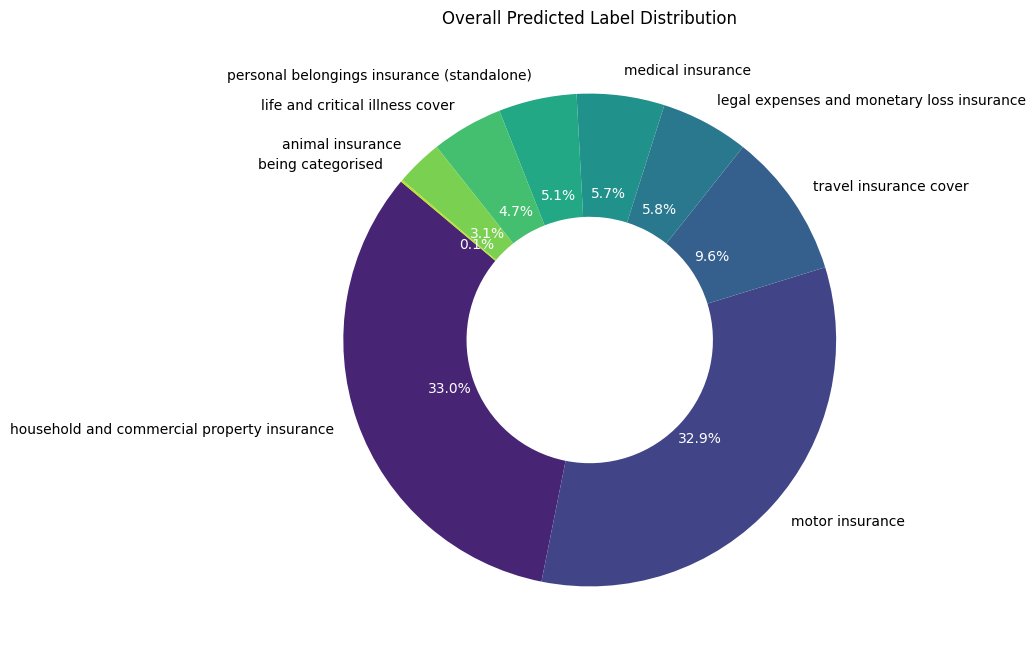

In [21]:
## Figure 2: Insurance type proportion

plt.figure(figsize=(8, 8))
insurance_counts = to_be_classify['predicted_label'].value_counts()
wedges, texts, ratiotexts = plt.pie(insurance_counts, labels=insurance_counts.index, autopct='%1.1f%%',
                                   startangle=140, colors=sns.color_palette('viridis', len(insurance_counts)),
                                   wedgeprops=dict(width=0.5))
# Set the ratio text of chart as white
for ratio in ratiotexts:
    ratio.set_color('white')
plt.title('Overall Predicted Label Distribution')
plt.show()

/tmp/ipykernel_18/4210051848.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_be_classify['date'] = pd.to_datetime(to_be_classify['date'])
/tmp/ipykernel_18/4210051848.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_be_classify['month'] = to_be_classify['date'].dt.to_period('M')


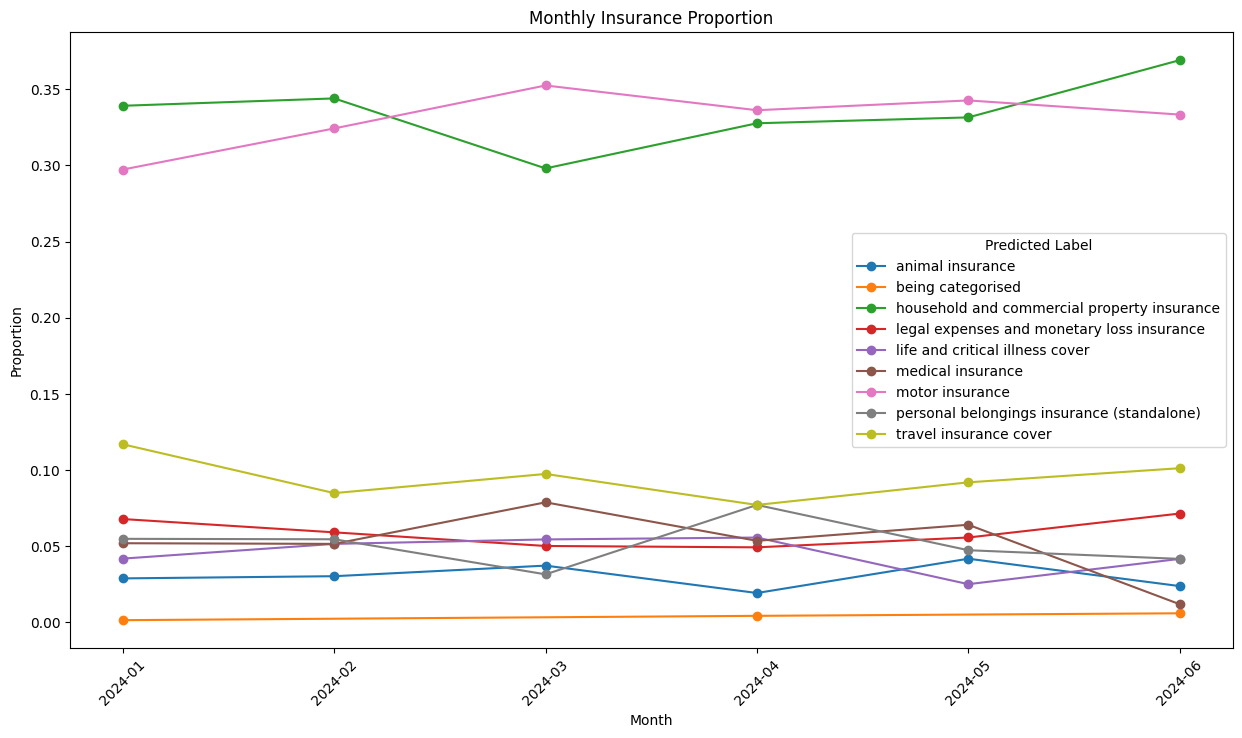

In [22]:
## Figure 3: Monthly insurance proportion

# Change the date of complaint cases as datetime formate and extract corresponding month
to_be_classify['date'] = pd.to_datetime(to_be_classify['date'])
to_be_classify['month'] = to_be_classify['date'].dt.to_period('M')
# Group by months and insurance type, calculate ratio
monthly_distribution = to_be_classify.groupby(['month', 'predicted_label']).size().reset_index(name='count')
monthly_totals = to_be_classify.groupby('month').size().reset_index(name='total')
monthly_distribution = monthly_distribution.merge(monthly_totals, on='month')
monthly_distribution['proportion'] = monthly_distribution['count'] / monthly_distribution['total']

# Visualization
plt.figure(figsize=(15, 8))
for label in monthly_distribution['predicted_label'].unique():
    monthly_label_distribution = monthly_distribution[monthly_distribution['predicted_label'] == label]
    plt.plot(monthly_label_distribution['month'].astype(str),
             monthly_label_distribution['proportion'], marker='o', label=label)
plt.title('Monthly Insurance Proportion')
plt.xlabel('Month')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.legend(title='Predicted Label')
plt.show()

### Complaint Reason Analysis

In [23]:
# Download punctuation words, stopwords
nltk.download('stopwords')
nltk.download('punkt')
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [24]:
# This function is used to pre-process text, including lower case, remove spaces,
# remove hyperlinks, e-mails, stopwords and lemmatize words
def preprocess_text(text):
    text = text.lower() # lower case
    text = re.sub(r'\s+', ' ', text).strip() # remove line breaks and extra spaces
    text = re.sub(r'\b\w+@\w+\.\w+\b', '', text) # remove e-mail
    text = re.sub(r'http[s]?://\S+', '', text) # remove hyperlinks
    text = re.sub(r'[0-9]+', '', text) # remove numbers
    text = re.sub(r'[^\w\s]', '', text) # remove punctuations
    tokens = word_tokenize(text)
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # lemmatize words
    doc = nlp(' '.join(tokens))
    lemmatized_tokens = [token.lemma_ for token in doc]
    # join as a large string
    processed_text = ' '.join(lemmatized_tokens)
    return processed_text

In [25]:
to_be_classify['cleaned_happened'] = to_be_classify['cleaned_happened'].apply(preprocess_text)

/tmp/ipykernel_18/1102752787.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_be_classify['cleaned_happened'] = to_be_classify['cleaned_happened'].apply(preprocess_text)


#### motor insurance

In [26]:
motor_original = to_be_classify[to_be_classify['predicted_label'] == 'motor insurance']
motor = motor_original.drop(columns=["The complaint"])

In [27]:
# Initialize YAKE!
language = "en"
max_ngram_size = 3 # the keywords should be in 3 words
deduplication_threshold = 0.9
numOfKeywords = 5 # extract 5 key phrases for each file
custom_kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size,
                                            dedupLim=deduplication_threshold, top=numOfKeywords, features=None)

In [28]:
# This function is used to extract key phrases in each file
def extract_top_keywords(text):
    keywords = custom_kw_extractor.extract_keywords(text)
    # Extract top 5 phrases ordered by correlation
    top_keywords = [kw[0] for kw in sorted(keywords, key=lambda x: x[1])[:numOfKeywords]]
    return ', '.join(top_keywords)

In [29]:
motor['top_keywords'] = motor['cleaned_happened'].apply(extract_top_keywords)

In [30]:
# Calculate frequency for all 3-words key phrases
def get_phrase_frequency(df, col_name):
    phrases = df[col_name].str.split(', ').explode()
    phrase_freq = Counter(phrases) 
    freq_df = pd.DataFrame(phrase_freq.items(),
                           columns=['Phrase', 'Frequency']).sort_values(by='Frequency', ascending=False)
    return freq_df

In [31]:
## Table 1: The most common three-word phrases

# Frequency for motor insurance
phrase_freq_df = get_phrase_frequency(motor, 'top_keywords')
phrase_freq_df.head(10)

,Phrase,Frequency
20,motor insurance policy,116
1,hold motor insurance,26
263,subject matter claim,19
113,deem total loss,16
31,make claim motor,15
795,party summarise event,15
32,claim motor insurance,14
29,car insurance policy,14
264,matter claim complaint,13
35,involve road traffic,13


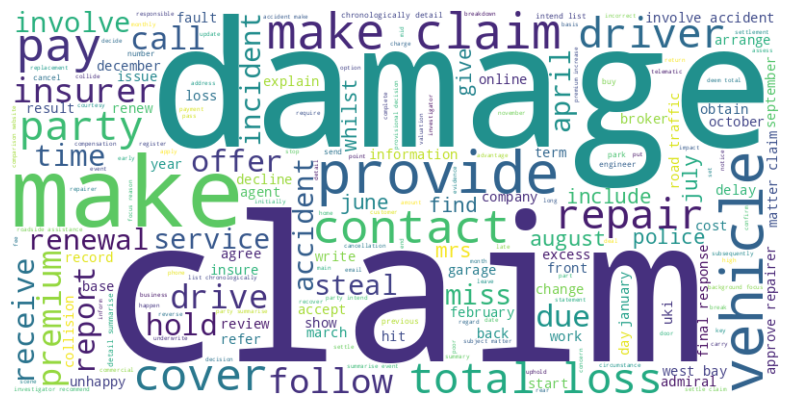

In [32]:
## Figure 4: Motor complaint reason wordcloud

# Join all words in a string
all_keywords = ', '.join(motor['top_keywords'])
# remove meaningless words
motor_to_remove = ['motor', 'insurance', 'policy', 'car', 'complaint',
                   'complained', 'complains', 'complain', 'question']
pattern = r'\b(?:' + '|'.join(motor_to_remove) + r')\b,?\s*'
new_keywords = re.sub(pattern, '', all_keywords)
motor_wordcloud = WordCloud(width=800, height=400, background_color='white',
                      colormap='viridis').generate(new_keywords)
plt.figure(figsize=(10, 5))
plt.imshow(motor_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#### Household and commercial property insurance

In [33]:
# This part repeats the same process as motor insurance
house_original = to_be_classify[to_be_classify['predicted_label'] == 'household and commercial property insurance']
house_clean = house_original.drop(columns=["The complaint"])

In [34]:
## Table 1: The most common three-word phrases

# Frequency for household and commercial property insurance
house_clean['top_keywords'] = house_clean['cleaned_happened'].apply(extract_top_keywords)
house_freq_df = get_phrase_frequency(house_clean, 'top_keywords')
house_freq_df.head(10)

,Phrase,Frequency
169,home insurance policy,74
127,circumstance complaint dispute,33
129,complaint dispute summarise,29
103,building content insurance,23
823,give reason reach,19
824,reason reach outcome,19
59,building insurance policy,19
60,insurance policy underwrite,19
482,hold building insurance,18
16,party summarise event,18


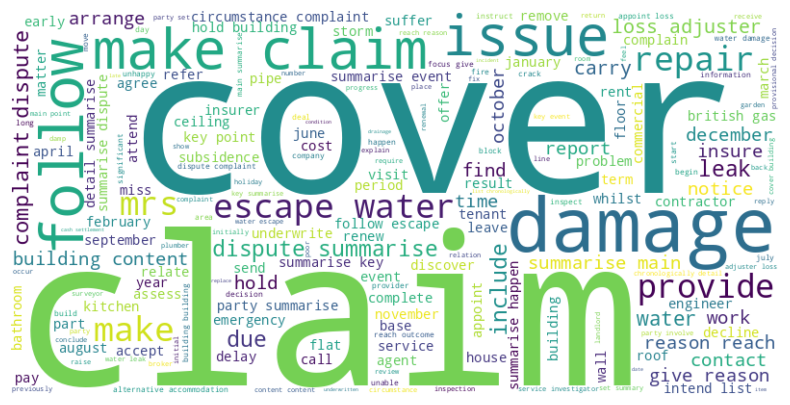

In [35]:
## Figure 5: Household and commercial property insurance complaint reason wordcloud


house_all_keywords = ', '.join(house_clean['top_keywords'])
house_to_remove = ['home', 'property', 'insurance', 'policy']
house_pattern = r'\b(?:' + '|'.join(house_to_remove) + r')\b,?\s*'
house_new_keywords = re.sub(house_pattern, '', house_all_keywords)

house_wordcloud = WordCloud(width=800, height=400, background_color='white',
                            colormap='viridis').generate(house_new_keywords)
plt.figure(figsize=(10, 5))
plt.imshow(house_wordcloud, interpolation='bilinear')
plt.axis('off') 
plt.show()

### Upheld and Not Upheld Analysis

In [36]:
to_be_classify.head()

,decision_id,date,company,decision,The complaint,What happened,cleaned_complaint,What happened_100,cleaned_happened,text,predicted_label,month
0,DRN-4841485,2024-06-11,Mulsanne Insurance Company Limited,Not upheld,Mr H complains that Mulsanne Insurance Company...,Mr H held a motor insurance policy with Mulsan...,mr h complains that mulsanne insurance company...,Mr H held a motor insurance policy with Mulsan...,mr h hold motor insurance policy mulsanne car ...,mr h complains that mulsanne insurance company...,motor insurance,2024-06
1,DRN-4798432,2024-06-11,One Insurance Limited,Upheld,Miss T complains about delays in assessing her...,Miss T had a home insurance policy with legal ...,miss t complains about delays in assessing her...,Miss T had a home insurance policy with legal ...,miss home insurance policy legal cover underwr...,miss t complains about delays in assessing her...,household and commercial property insurance,2024-06
2,DRN-4841285,2024-06-11,Ageas Insurance Limited,Upheld,Mr G is a sole trader. He complains that Ageas...,Mr G operates in the motor industry. He took o...,mr g is a sole trader he complains that ageas...,Mr G operates in the motor industry. He took o...,mr g operate motor industry take motor trade r...,mr g is a sole trader he complains that ageas...,motor insurance,2024-06
3,DRN-4842247,2024-06-11,AWP P&C S.A.,Not upheld,Mr and Mrs E have complained that AWP P&C SA d...,Mr and Mrs E and their two children were on ho...,mr and mrs e have complained that awp p c sa d...,Mr and Mrs E and their two children were on ho...,mr mrs e two child holiday abroad use car part...,mr and mrs e have complained that awp p c sa d...,travel insurance cover,2024-06
4,DRN-4846269,2024-06-11,esure Insurance Limited,Not upheld,Mr H and Mr H complain that esure Insurance Li...,Mr H has car insurance with esure. In Februar...,mr h and mr h complain that esure insurance li...,Mr H has car insurance with esure. In February...,mr h car insurance esure february mr h involve...,mr h and mr h complain that esure insurance li...,motor insurance,2024-06


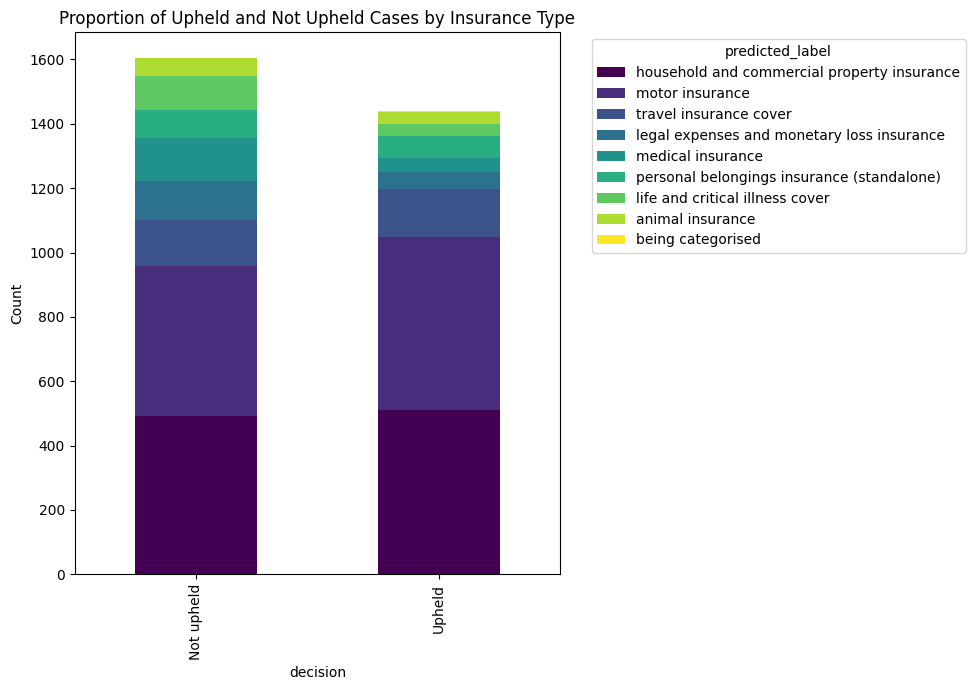

In [37]:
## Figure 6: Proportion of upheld and not upheld cases by insurance type

# Calculate the number of each insurance type
type_counts = to_be_classify.groupby(['decision', 'predicted_label']).size().reset_index(name='count')
type_counts = type_counts.sort_values(by=['decision', 'predicted_label'], ascending=[True, False])

# Plot stacked bar chart
stacked = type_counts.pivot(index='decision', columns='predicted_label', values='count').fillna(0)
# Sort in descending order
stacked = stacked[stacked.sum().sort_values(ascending=False).index]
stacked.plot(kind='bar', stacked=True, figsize=(10, 7), colormap='viridis')
plt.title('Proportion of Upheld and Not Upheld Cases by Insurance Type')
plt.xlabel('decision')
plt.ylabel('Count')
plt.legend(title='predicted_label', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [38]:
# The function plots wordcloud
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, size=15)
    plt.axis('off')
    plt.show()

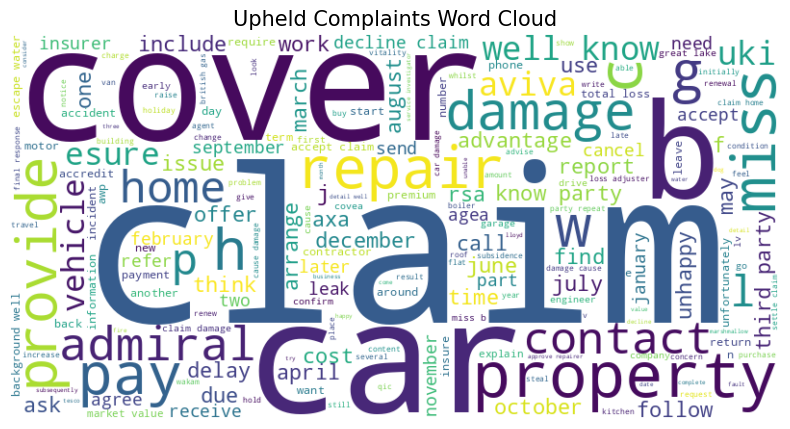

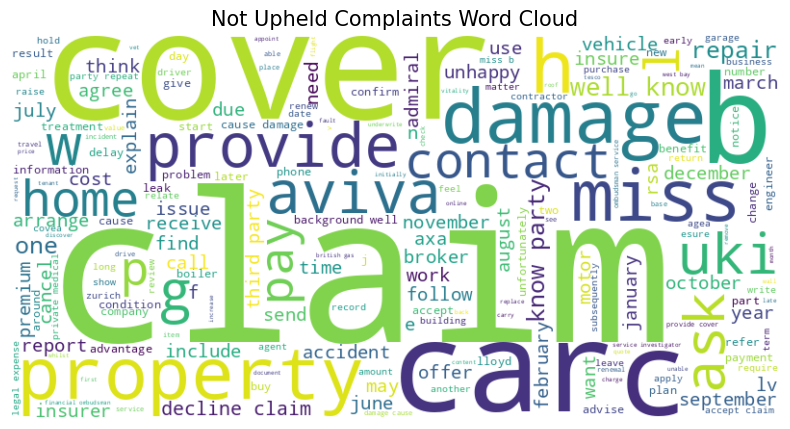

In [39]:
## Figure 7: Upheld and not upheld wordcloud

# The process is similar to the process of complaint reason analysis
upheld_text = ' '.join(to_be_classify[to_be_classify['decision'] == 'Upheld']['cleaned_happened'])
not_upheld_text = ' '.join(to_be_classify[to_be_classify['decision'] == 'Not upheld']['cleaned_happened'])
held_remove = ['insurance', 'policy', 'complaint', 'complain', 'question', 'mr', 'mrs', 'ms', 'say',
                  'tell', 'make', 'take']
held_pattern = r'\b(?:' + '|'.join(held_remove) + r')\b,?\s*'
upheld = re.sub(held_pattern, '', upheld_text)
not_upheld = re.sub(held_pattern, '', not_upheld_text)

generate_wordcloud(upheld, 'Upheld Complaints Word Cloud')
generate_wordcloud(not_upheld, 'Not Upheld Complaints Word Cloud')

## Binary Decision Model

In [40]:
# Replace claim outcomes as numbers
pdf_clean['decision'] = pdf_clean['decision'].replace({'Not upheld': 0, 'Upheld': 1})
total_feature = pdf_clean.drop(columns=["The complaint", "What happened_100", "cleaned_complaint",
                                     "cleaned_happened", "text"])
total_feature.head()

/tmp/ipykernel_18/2687958357.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pdf_clean['decision'] = pdf_clean['decision'].replace({'Not upheld': 0, 'Upheld': 1})


,decision_id,date,company,decision,What happened
0,DRN-4841485,11 Jun 2024,Mulsanne Insurance Company Limited,0,Mr H held a motor insurance policy with Mulsan...
1,DRN-4798432,11 Jun 2024,One Insurance Limited,1,Miss T had a home insurance policy with legal ...
2,DRN-4841285,11 Jun 2024,Ageas Insurance Limited,1,Mr G operates in the motor industry. He took o...
3,DRN-4842247,11 Jun 2024,AWP P&C S.A.,0,Mr and Mrs E and their two children were on ho...
4,DRN-4846269,11 Jun 2024,esure Insurance Limited,0,Mr H has car insurance with esure. In Februar...


In [41]:
meaningless = ['mr', 'mrs', 'ms', 'miss', 'uk']
# Remove meaningless words
def remove_meaningless(text):
    tokens = text.split()
    filtered_tokens = [token for token in tokens if token not in meaningless]
    return ' '.join(filtered_tokens)

In [42]:
# Pre-process words
total_feature['meaningful'] = total_feature['What happened'].apply(preprocess_text)
total_feature['meaningful'] = total_feature['meaningful'].apply(remove_meaningless)
total_feature.head()

,decision_id,date,company,decision,What happened,meaningful
0,DRN-4841485,11 Jun 2024,Mulsanne Insurance Company Limited,0,Mr H held a motor insurance policy with Mulsan...,h hold motor insurance policy mulsanne car ste...
1,DRN-4798432,11 Jun 2024,One Insurance Limited,1,Miss T had a home insurance policy with legal ...,home insurance policy legal cover underwrite o...
2,DRN-4841285,11 Jun 2024,Ageas Insurance Limited,1,Mr G operates in the motor industry. He took o...,g operate motor industry take motor trade road...
3,DRN-4842247,11 Jun 2024,AWP P&C S.A.,0,Mr and Mrs E and their two children were on ho...,e two child holiday abroad use car particular ...
4,DRN-4846269,11 Jun 2024,esure Insurance Limited,0,Mr H has car insurance with esure. In Februar...,h car insurance esure february h involve minor...


### Extract top 512 TF-IDF features

In [43]:
# This function is used to obtain features and name based on importance
def get_top_512_words(row, feature, n=512):
    indices = row.indices
    top_indices = indices[:n] 
    top_words = [feature[i] for i in top_indices]
    return ' '.join(top_words)

In [44]:
text_vectorizer = TfidfVectorizer(max_features=512) 
tfidf_matrix = text_vectorizer.fit_transform(total_feature['meaningful'])
feature = text_vectorizer.get_feature_names_out()
total_feature['tfidf'] = [get_top_512_words(row, feature) for row in tfidf_matrix]

In [45]:
total_feature.head()

,decision_id,date,company,decision,What happened,meaningful,tfidf
0,DRN-4841485,11 Jun 2024,Mulsanne Insurance Company Limited,0,Mr H held a motor insurance policy with Mulsan...,h hold motor insurance policy mulsanne car ste...,july accept ombudsman financial rule uphold fi...
1,DRN-4798432,11 Jun 2024,One Insurance Limited,1,Miss T had a home insurance policy with legal ...,home insurance policy legal cover underwrite o...,limit right thing put within still even suppor...
2,DRN-4841285,11 Jun 2024,Ageas Insurance Limited,1,Mr G operates in the motor industry. He took o...,g operate motor industry take motor trade road...,although enough period day report appreciate m...
3,DRN-4842247,11 Jun 2024,AWP P&C S.A.,0,Mr and Mrs E and their two children were on ho...,e two child holiday abroad use car particular ...,unable already carry family definition key tra...
4,DRN-4846269,11 Jun 2024,esure Insurance Limited,0,Mr H has car insurance with esure. In Februar...,h car insurance esure february h involve minor...,resolve payment company lead anything purchase...


### Logistic Regression Classification Model

In [46]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    total_feature['tfidf'],
    total_feature['decision'], test_size=0.25, random_state=42
)

In [47]:
## Table 5: Results of Logistic Regression Classification Model

model_logi = make_pipeline(TfidfVectorizer(), LogisticRegression())
model_logi.fit(train_texts, train_labels)
train_pred = model_logi.predict(train_texts)
test_pred = model_logi.predict(test_texts)
print(classification_report(train_labels, train_pred))
print(classification_report(test_labels, test_pred))

              precision    recall  f1-score   support

           0       0.89      0.90      0.90      1255
           1       0.89      0.88      0.89      1154

    accuracy                           0.89      2409
   macro avg       0.89      0.89      0.89      2409
weighted avg       0.89      0.89      0.89      2409

              precision    recall  f1-score   support

           0       0.84      0.85      0.85       423
           1       0.83      0.82      0.83       380

    accuracy                           0.84       803
   macro avg       0.84      0.84      0.84       803
weighted avg       0.84      0.84      0.84       803



### SpaCy Classification Model

In [48]:
# Create training set and test set
texts = total_feature['tfidf'].tolist()
labels = total_feature['decision'].tolist()
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.25, random_state=42)

In [49]:
# Load a blank SpaCy Model
spacy_decision = spacy.blank('en')
# Add textcat to pipeline
if 'textcat' not in spacy_decision.pipe_names:
    textcat = spacy_decision.add_pipe('textcat', last=True)
else:
    textcat = spacy_decision.get_pipe('textcat')
# Add labels to textcat
textcat.add_label("LABEL_0")
textcat.add_label("LABEL_1")
# Create DocBin Instance and add data into it
def create_docbin(texts, labels, spacy_decision):
    doc_bin = DocBin()
    # Zip compliant text and labels
    for text, label in zip(texts, labels):
        doc = spacy_decision.make_doc(text)
        cats = {"LABEL_0": 1.0 if label == 0 else 0.0, "LABEL_1": 1.0 if label == 1 else 0.0}
        doc.cats = cats
        doc_bin.add(doc)
    return doc_bin
train_doc_bin = create_docbin(X_train, y_train, spacy_decision)
test_doc_bin = create_docbin(X_test, y_test, spacy_decision)

In [50]:
# The codes in this cell is the process of training SpaCy Classification Model. 
# If you only would like to use trained weights to predict final decision,
# you can comment this cell and directly run the next two cells.
# If you would like to train, then just run this cell
# The results may have small differences from paper.

## Table 6: Losses of SpaCy Classification Model.


# This function can be used to train the SpaCy model
def train_spacy_model(spacy_decision, train_data, n_iter=10):
    optim = spacy_decision.begin_training()
    for i in range(n_iter):
        losses = {}
        batches = minibatch(train_spacy, size=compounding(15.0, 32.0, 1.001))
        # Update for each batch
        for batch in batches:
            spacy_decision.update(batch, sgd=optim, drop=0.5, losses=losses)
        print(f"Iteration {i} - Loss: {losses['textcat']}")

# Prepare for training data
train_spacy = []
for doc in train_doc_bin.get_docs(spacy_decision.vocab):
    train_spacy.append(Example.from_dict(doc, {"cats": doc.cats}))
# Train the model
train_spacy_model(spacy_decision, train_spacy, n_iter=15)

# Save SpaCy Model
spacy_decision.to_disk("/kaggle/working/Spacy/")

[2024-08-07 21:59:06,468] [INFO] Created vocabulary
[2024-08-07 21:59:06,469] [INFO] Finished initializing nlp object


Iteration 0 - Loss: 38.39262738823891
Iteration 1 - Loss: 32.29313453659415
Iteration 2 - Loss: 25.35971325263381
Iteration 3 - Loss: 23.223111674189568
Iteration 4 - Loss: 21.424156177788973
Iteration 5 - Loss: 20.010666638612747
Iteration 6 - Loss: 18.584873091429472
Iteration 7 - Loss: 18.120901877060533
Iteration 8 - Loss: 17.304998044855893
Iteration 9 - Loss: 18.21636937186122
Iteration 10 - Loss: 16.684796851594
Iteration 11 - Loss: 16.412411110824905
Iteration 12 - Loss: 16.595906398026273
Iteration 13 - Loss: 15.564828615169972
Iteration 14 - Loss: 15.151229287032038


In [51]:
import spacy
from spacy.tokens import DocBin
from spacy.training import Example
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, accuracy_score

# Load saved SpaCy Model
save_spacy_decision = spacy.load("/kaggle/input/half-year-data/Spacyweights/Spacy")

# This function is to predict the claim outcome of cases in test set
def predict(spacy_decision, texts):
    documents = [spacy_decision.make_doc(text) for text in texts]
    scores = spacy_decision.pipe(documents, disable=["tagger", "parser"])
    predictions = []
    # predict label based on scores
    for score in scores:
        if score.cats["LABEL_0"] > score.cats["LABEL_1"]:
            predictions.append(0)
        else:
            predictions.append(1)
    return predictions

# This function evaluates SpaCy model by accuracy, precision, recall, f1-score
def evaluate_model(spacy_decision, data):
    texts = [example.reference.text for example in data]
    true_labels = [1 if example.reference.cats['LABEL_1'] > 0.5 else 0 for example in data]
    pred_labels = predict(spacy_decision, texts)
    
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='binary')
    tn, fp, fn, tp = confusion_matrix(true_labels, pred_labels).ravel()
    accuracy = accuracy_score(true_labels, pred_labels)
    return precision, recall, f1, accuracy

In [52]:
## Table 7: Results of SpaCy Classification Model

# Prepare training data and testing data
train_spacy = []
for doc in train_doc_bin.get_docs(save_spacy_decision.vocab):
    train_spacy.append(Example.from_dict(doc, {"cats": doc.cats}))
test_examples = []
for doc in test_doc_bin.get_docs(save_spacy_decision.vocab):
    test_examples.append(Example.from_dict(doc, {"cats": doc.cats}))

# Evaluate training set and testing set
train_precision, train_recall, train_f1, train_accuracy = evaluate_model(save_spacy_decision, train_spacy)
print(f"Train Accuracy: {train_accuracy}, Precision: {train_precision}, Recall: {train_recall}, F1-Score: {train_f1}")
test_precision, test_recall, test_f1, test_accuracy = evaluate_model(save_spacy_decision, test_examples)
print(f"Test Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1-Score: {test_f1}")

Train Accuracy: 0.8488999584889996, Precision: 0.76797829036635, Recall: 0.9809358752166378, F1-Score: 0.8614916286149162
Test Accuracy: 0.7920298879202988, Precision: 0.7067961165048544, Recall: 0.9578947368421052, F1-Score: 0.8134078212290503
